# Basic Data Exploration Using Our Data

Here we will showcase the 3 different directories and specifically their benefits for different types of problems.

In [1]:
import os
os.chdir('./data/game_by_game/')
import csv
from re import split
import string
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

The directory with the most obvious use cases is the directory with individual games, so we'll explore that data first.

## Game by Game

A basic concept we may want to be able to get an idea of is who had the "best game" during a particular season, whether it be who had the most points or we assign a value to different statistics.  But how do you define "best game?"  You can't *really*, this is one of those abstract ideas that requires what sports often call "The Eye Test."  So the focus from a data science standpoint shifts to finding the best few games played during a particular season so that we can allow a human to look at statistics from those games and decide from there.

In order to do this, we first need to figure out what stats we have access to during the seasons we're looking at.  Here, we'll look at the 2010's (here we define "2010's" as any season whose championship game was played during 2010-2019).

In [2]:
files_by_season = {year:[] for year in range(2010,2020)}

for file_name in os.listdir():
    year = int(split('_| ', file_name[:-4])[-1])
    if year in files_by_season.keys():
        files_by_season[year].append(file_name)

In [3]:
stats_by_year = {}
for year in files_by_season.keys():
    with open(files_by_season[year][0], 'r') as csv_file:
        reader = csv.DictReader(csv_file)
        for row in reader:
            stats_by_year[year] = list(row.keys())
            break
stats_by_year[2010]

['date',
 'age',
 'team_id',
 'game_location',
 'opp_id',
 'game_result',
 'gs',
 'mp',
 'fg',
 'fga',
 'fg_pct',
 'fg3',
 'fg3a',
 'fg3_pct',
 'ft',
 'fta',
 'ft_pct',
 'orb',
 'drb',
 'trb',
 'ast',
 'stl',
 'blk',
 'tov',
 'pf',
 'pts',
 'game_score',
 'plus_minus',
 'game_season']

It turns out that the NBA has a stat called [Game Score](https://www.nba.com/resources/static/team/v2/thunder/statlab-gamescore-191201.pdf), which, with some basic research, we learn that it is exactly as we described previously by assigning values to different statistics in such a way that it roughly compares how productive people's games are relative to one another.  So we can start by just finding the top several Game Scores of each season and going from there!

In [4]:
def get_game_score(game):
    return float(game['game_score'])

data_by_year = {year:[] for year in range(2010, 2020)}
for year, file_name_list in files_by_season.items():
    for file_name in file_name_list:
        with open(file_name, 'r') as csv_file:
            reader = csv.DictReader(csv_file)
            for row in reader:
                data_by_year[year].append(row)
                data_by_year[year][-1]['name'] = split('_', file_name)[0]
    data_by_year[year] = sorted(data_by_year[year], key=get_game_score, reverse=True)[:100]

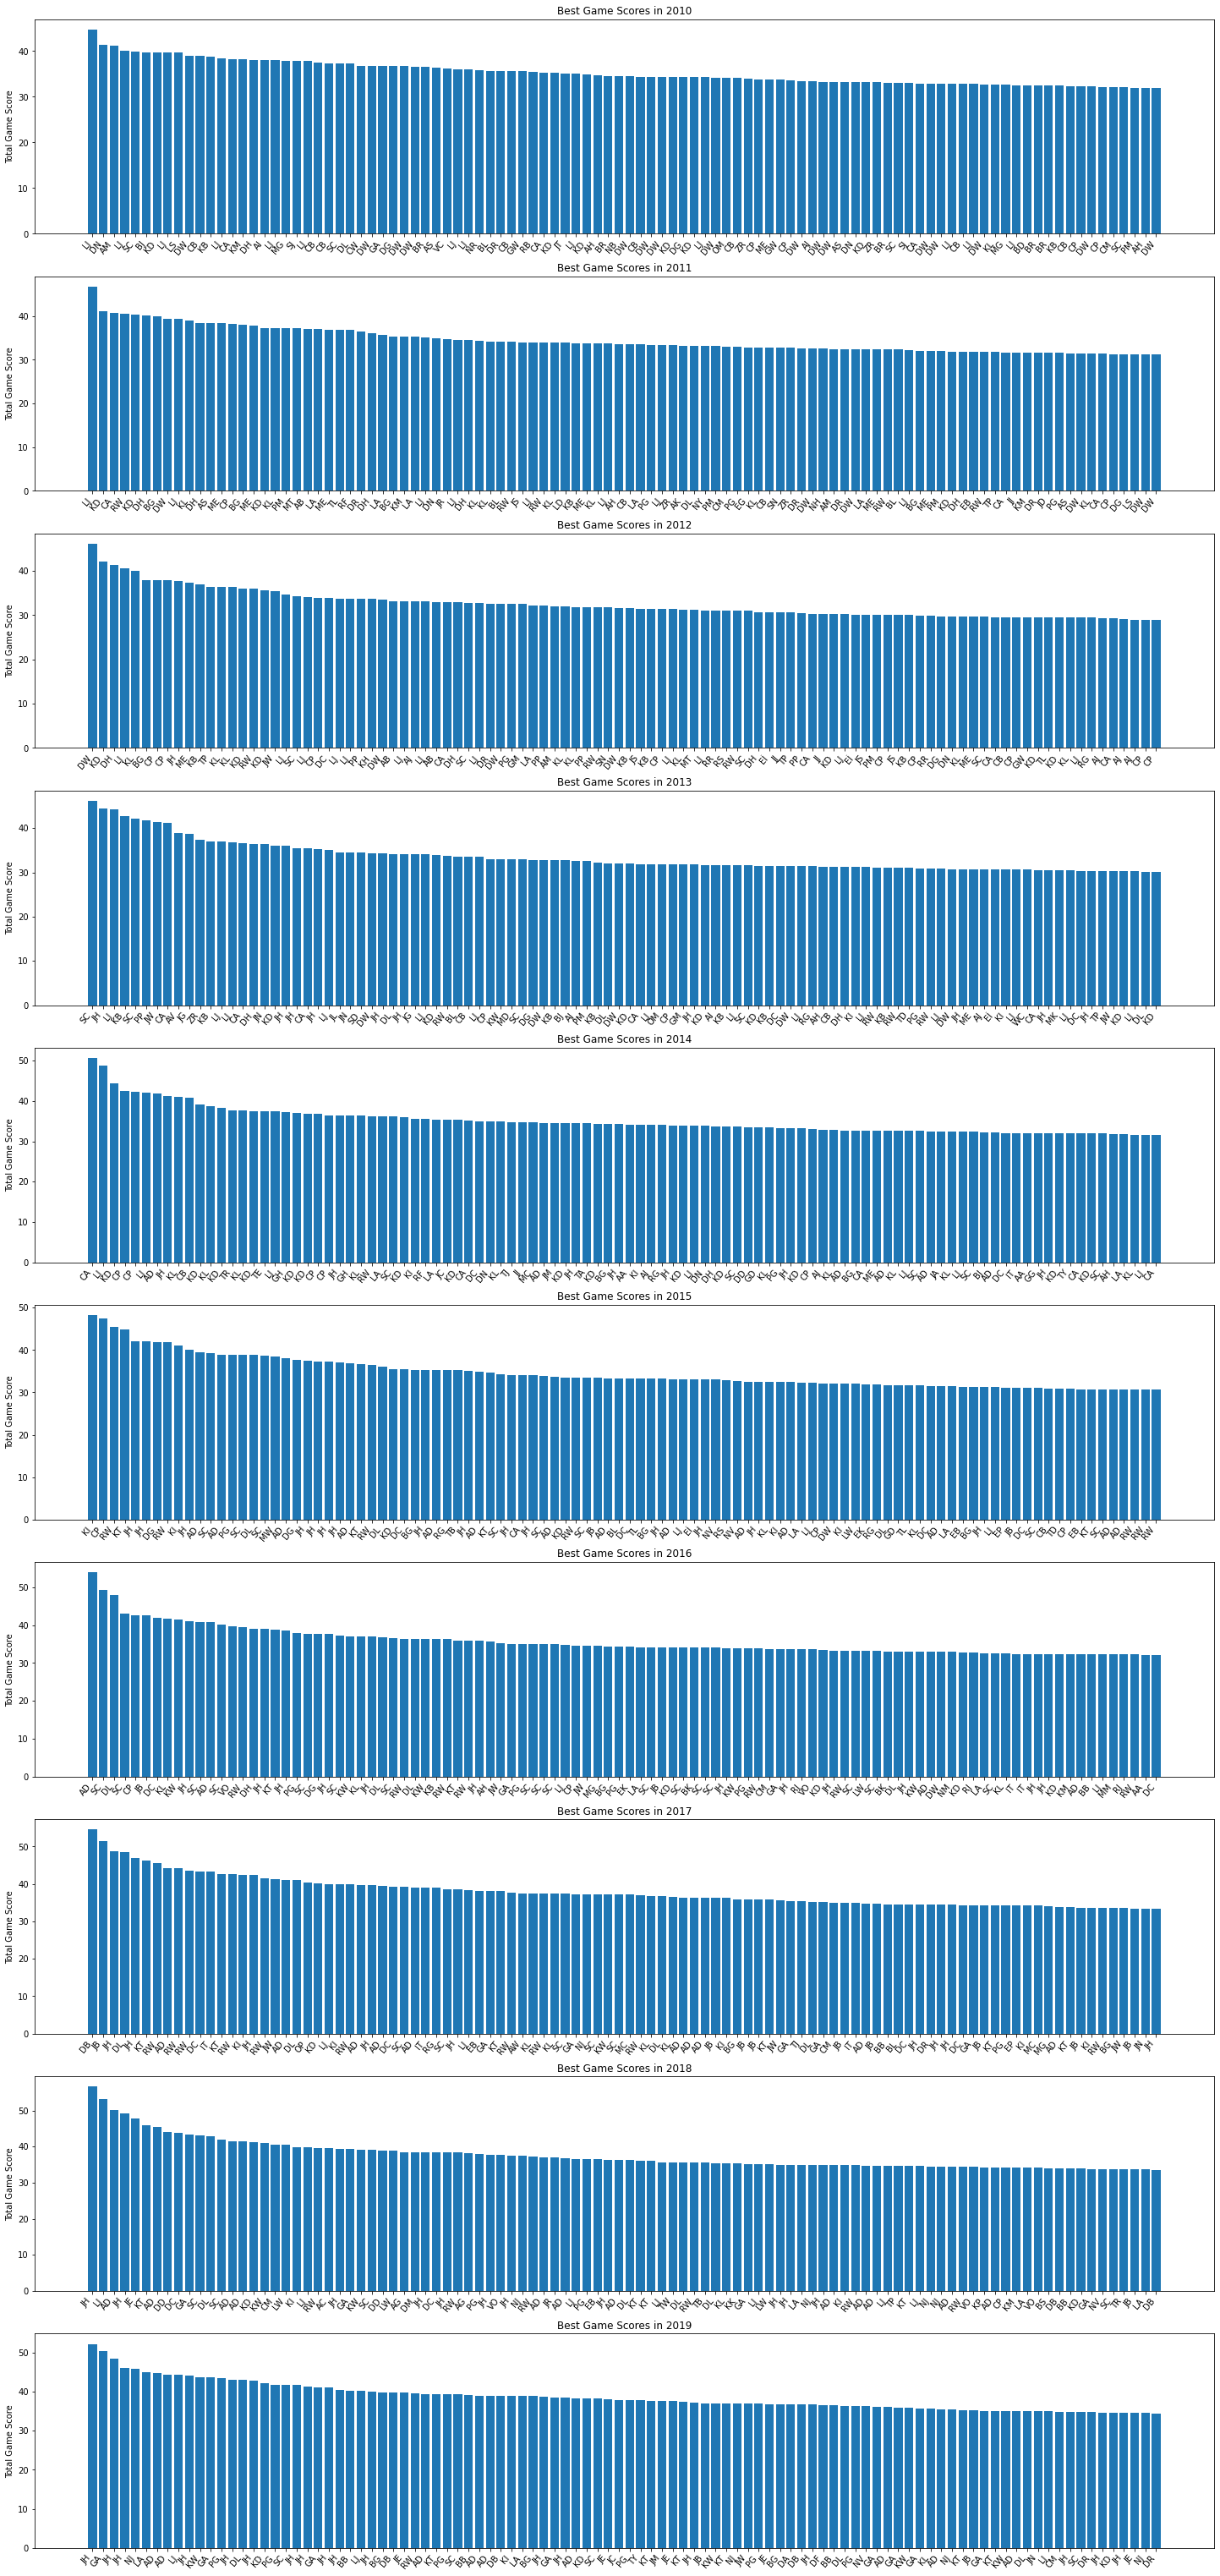

In [5]:
def get_initials(game):
    full_name = split(' ', game['name'])
    return full_name[0][0] + full_name[-1][0]

fig, ax = plt.subplots(10, figsize=(25,5.5*10))

for i in range(10):
    ax[i].bar([i for i in range(len(data_by_year[2010+i]))], [get_game_score(game) for game in data_by_year[2010+i]]);
    ax[i].set_xticks([i for i in range(len(data_by_year[2010+i]))])
    ax[i].set_xticklabels([get_initials(game) for game in data_by_year[2010+i]], rotation=50, ha='right');
    ax[i].title.set_text('Best Game Scores in {}'.format(2010+i))

plt.setp(ax, ylabel='Total Game Score')
    
plt.show()

It would be easy enough to just take the best game score and call it a day, but there's more than one way to decide who had the best game than strictly who had the highest (although it's probably a safe assumption that the best game would land in the top 100 game scores).

There are two different types of "pop-off" games by individual players.  There are the close games where he plays deep into the 4th quarter and/or overtime, then there are games where Klay Thompson drops 60 points and is benched at the end of the 3rd quarter in a blowout victory.  Because of this, there are plenty of games where players are playing well but are cut short even though they could have continued to torch the other team.  To account for this, we can first create a similar plot except instead of plotting total game score, we'll have game score per minute.

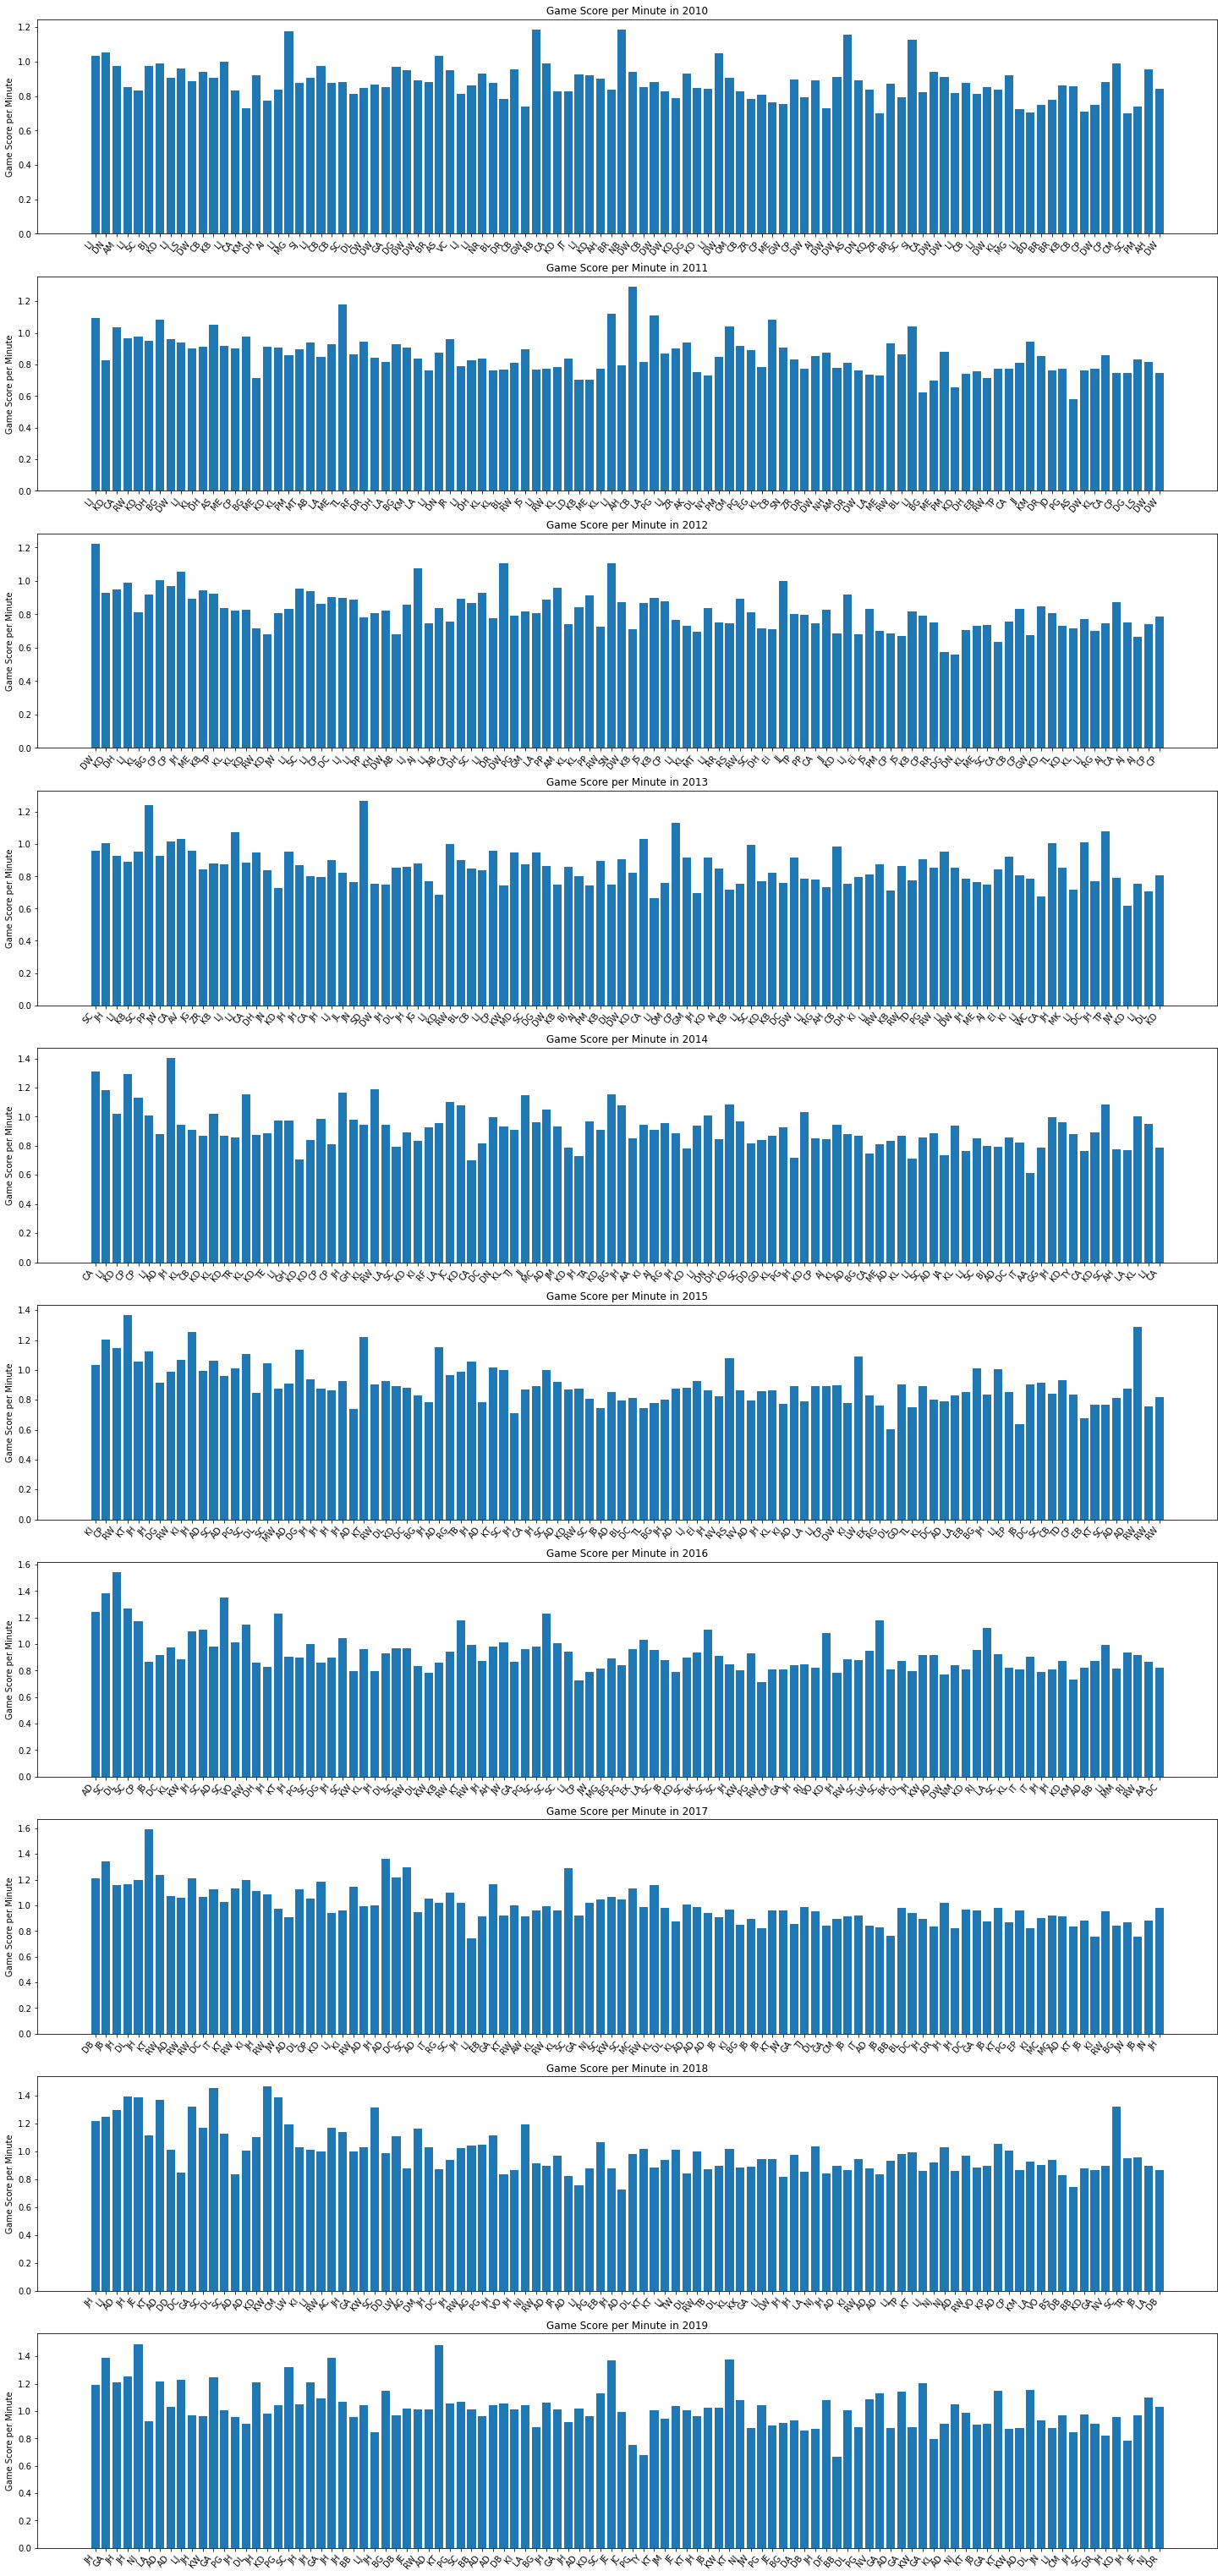

In [6]:
def get_game_score_per_minute(game):
    game_score = float(game['game_score'])
    minutes = game['mp'].split(':')
    minutes_played = float(minutes[0]) + float(minutes[1])/60
    return game_score/minutes_played

fig, ax = plt.subplots(10, figsize=(25,5.5*10))

for i in range(10):
    ax[i].bar([i for i in range(len(data_by_year[2010+i]))], [get_game_score_per_minute(game) for game in data_by_year[2010+i]]);
    ax[i].set_xticks([i for i in range(len(data_by_year[2010+i]))])
    ax[i].set_xticklabels([get_initials(game) for game in data_by_year[2010+i]], rotation=50, ha='right');
    ax[i].title.set_text('Game Score per Minute in {}'.format(2010+i))

plt.setp(ax, ylabel='Game Score per Minute')
    
plt.show()

This certainly shows that there's some merit to the idea that total game score isn't the perfect metric, however it's similarly wrong to use solely these plots.  A great way to get a "proper" comparison would be to create a scatter plot comparing total game score and minutes played.  Idealy, we want to find points that are high, but near the x-axis.

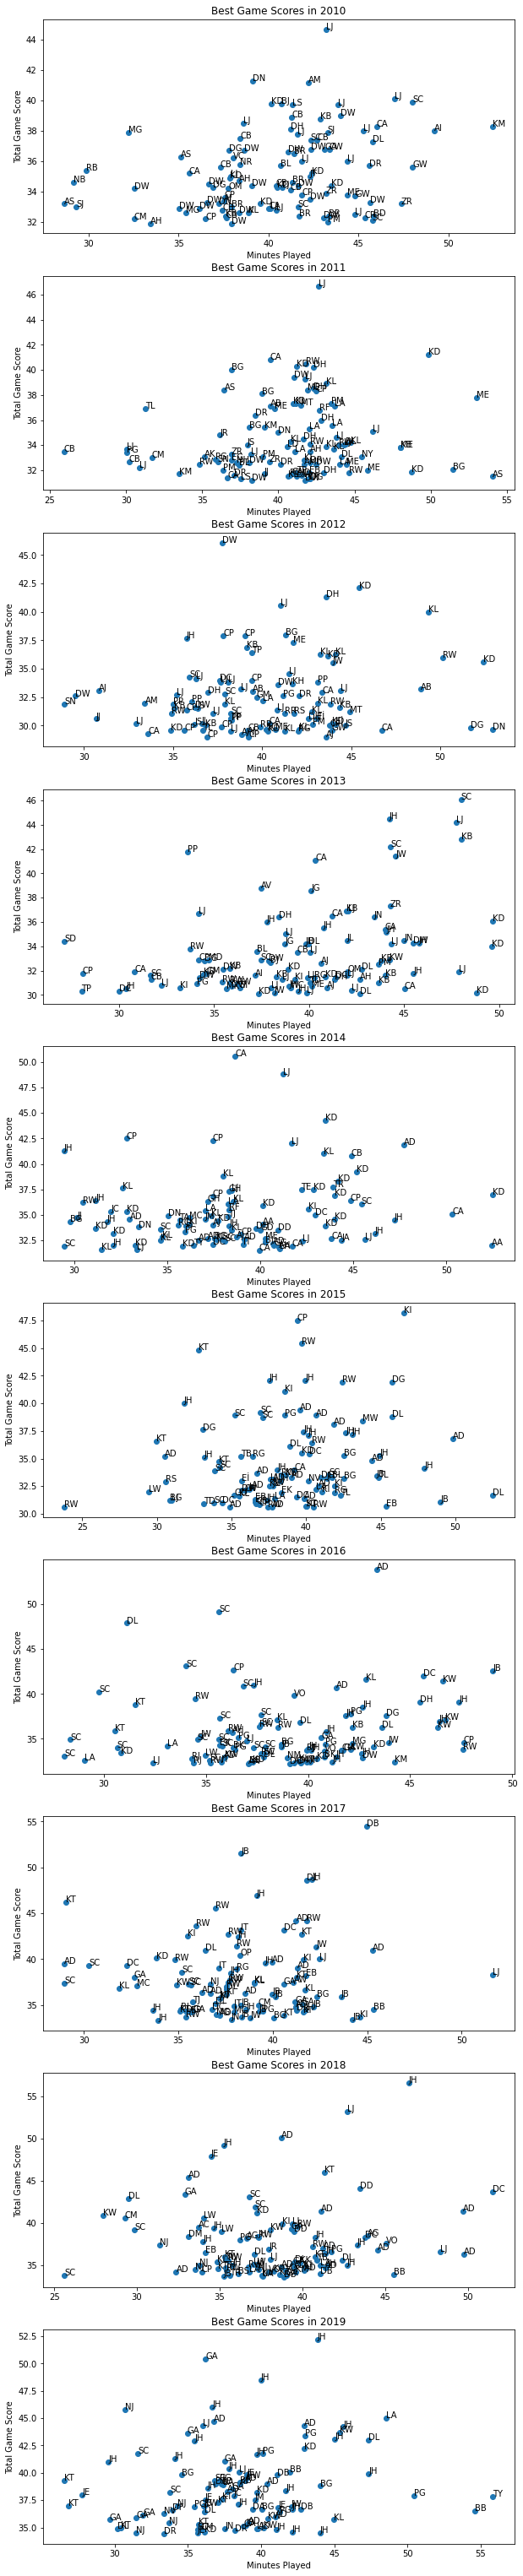

In [7]:
def get_minutes_played(game):
    minutes = game['mp'].split(':')
    return float(minutes[0]) + float(minutes[1])/60

fig, ax = plt.subplots(10, figsize=(10,5.5*10))

for i in range(10):
    minutes_played = [get_minutes_played(game) for game in data_by_year[2010+i]]
    game_scores = [get_game_score(game) for game in data_by_year[2010+i]]
    initials = [get_initials(game) for game in data_by_year[2010+i]]
    ax[i].scatter(minutes_played, game_scores);
    for j in range(len(minutes_played)):
        ax[i].annotate(initials[j], xy=(minutes_played[j], game_scores[j]));
#     ax[i].annotate(['LJ'], )
    ax[i].title.set_text('Best Game Scores in {}'.format(2010+i))

plt.setp(ax, xlabel='Minutes Played', ylabel='Total Game Score')

plt.show()

From these graphs, there are several points in each that pop out.  All of them, as previously mentioned, are towards the top and left of the graphs.  There exists an algorithm that will automatically go grab each of these points so that we can look at individual stats from each game and go from there.

In [8]:
def top_left_jarvis_march(points):
    '''
    This version of the Jarvis March will only return the values on the convex hull
    in the top left portion of the graph.
    '''
    champ = points[0]
    max_y = -float('infinity')
    for point in points:
        if get_minutes_played(point) < get_minutes_played(champ):
            champ = point
        if get_game_score(point) > max_y:
            max_y = get_game_score(point)
    points_on_hull = [champ]
    cur_point = champ
    step = 0
    while get_game_score(cur_point) != max_y:
        max_slope = -float('infinity')
        for point in points:
            if point == cur_point or get_minutes_played(point) < get_minutes_played(cur_point):
                continue
            cur_slope = (get_game_score(point)-get_game_score(cur_point))/(get_minutes_played(point)-get_minutes_played(cur_point) + 1e-5)
            if cur_slope > max_slope:
                max_slope = cur_slope
                best_point = point
        if max_slope < 10: # we get rid of points that are "basically" strictly a lower game score with same minutes played
            points_on_hull.append(best_point)
        else:
            points_on_hull[-1] = best_point
        cur_point = best_point
    return points_on_hull

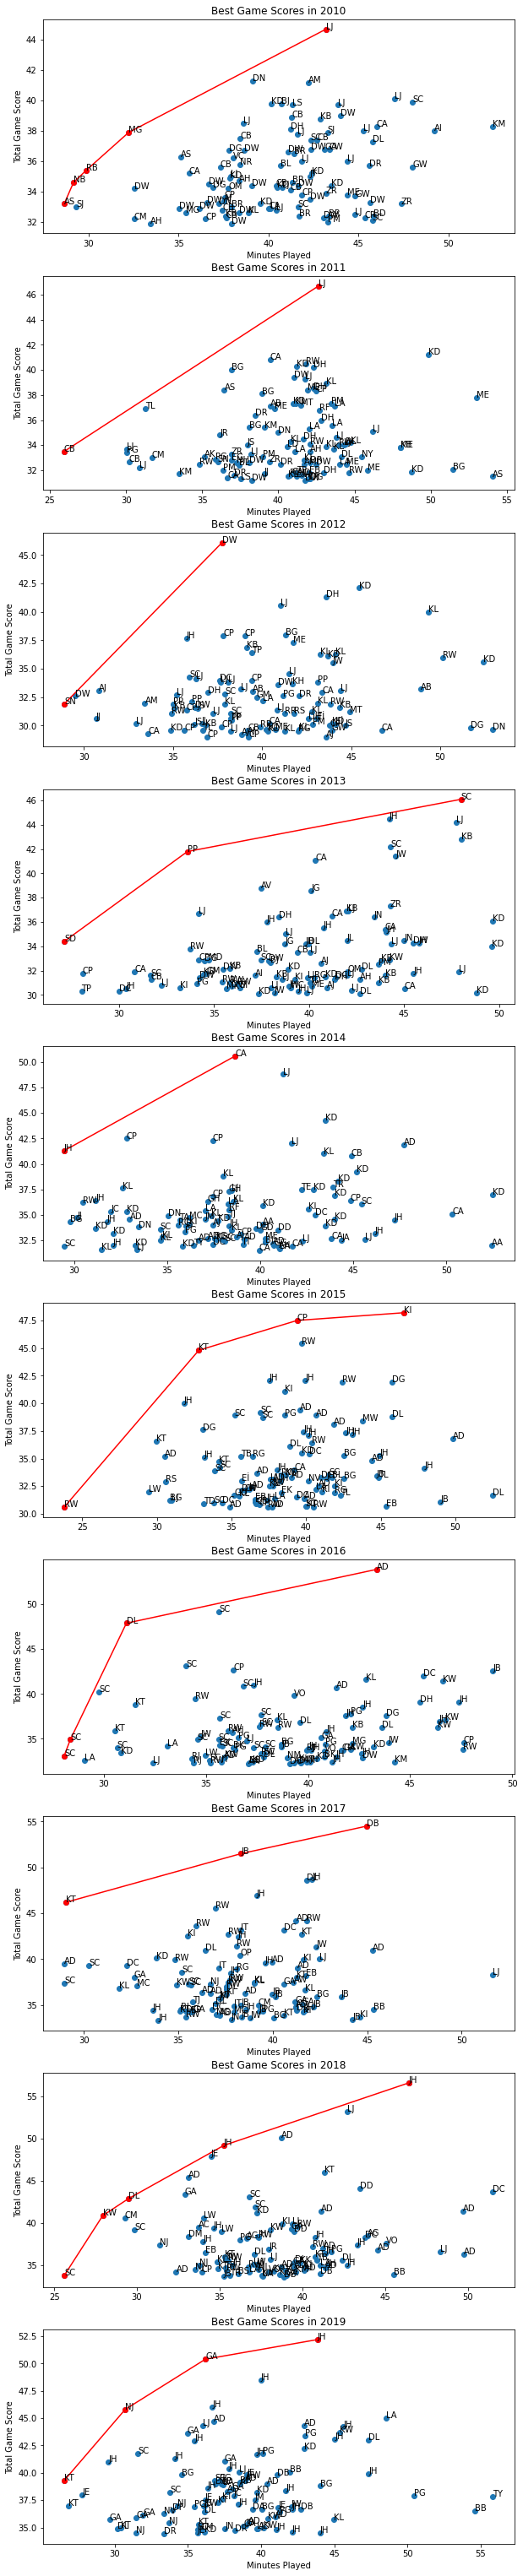

In [9]:
fig, ax = plt.subplots(10, figsize=(10,5.5*10))

for i in range(10):
    minutes_played = [get_minutes_played(game) for game in data_by_year[2010+i]]
    game_scores = [get_game_score(game) for game in data_by_year[2010+i]]
    initials = [get_initials(game) for game in data_by_year[2010+i]]
    convex_hull = top_left_jarvis_march(data_by_year[2010+i])
    ch_mp = [get_minutes_played(game) for game in convex_hull]
    ch_gs = [get_game_score(game) for game in convex_hull]
    ax[i].scatter(minutes_played, game_scores);
    for j in range(len(minutes_played)):
        ax[i].annotate(initials[j], xy=(minutes_played[j], game_scores[j]));
#     ax[i].annotate(['LJ'], )
    ax[i].plot(ch_mp, ch_gs, '-o', color='red')
    ax[i].title.set_text('Best Game Scores in {}'.format(2010+i))

plt.setp(ax, xlabel='Minutes Played', ylabel='Total Game Score')

plt.show()

From these graphs, we have very few games to look at per season that may potentially be worthy of being named the "best game of the season."  Since we've narrowed down the search so much, we can start looking at individual statistics of each game, as well as even find highlights online.

We'll focus now on the 2019 season as that is an interesting set of games to look at.  First, let's just observe the stats.

In [10]:
# https://stackoverflow.com/a/3229493
def pretty_print(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key) + ':')
        if isinstance(value, dict):
            pretty_print(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))


for game in convex_hull:
    print(game['name'])
    print(game)
    print('\n')

Klay Thompson
{'date': '2018-10-29', 'age': '28-263', 'team_id': 'GSW', 'game_location': '@', 'opp_id': 'CHI', 'game_result': 'W (+25)', 'gs': '1.0', 'mp': '26:33', 'fg': '18.0', 'fga': '29.0', 'fg_pct': '0.621', 'fg3': '14.0', 'fg3a': '24.0', 'fg3_pct': '0.583', 'ft': '2.0', 'fta': '2.0', 'ft_pct': '1.0', 'orb': '0.0', 'drb': '4.0', 'trb': '4.0', 'ast': '0.0', 'stl': '2.0', 'blk': '0.0', 'tov': '2.0', 'pf': '2.0', 'pts': '52.0', 'game_score': '39.3', 'plus_minus': '28.0', 'game_season': '9.0', 'name': 'Klay Thompson'}


Nikola Jokić
{'date': '2018-10-20', 'age': '23-243', 'team_id': 'DEN', 'game_location': '', 'opp_id': 'PHO', 'game_result': 'W (+28)', 'gs': '1.0', 'mp': '30:43', 'fg': '11.0', 'fga': '11.0', 'fg_pct': '1.0', 'fg3': '3.0', 'fg3a': '3.0', 'fg3_pct': '1.0', 'ft': '10.0', 'fta': '11.0', 'ft_pct': '0.909', 'orb': '0.0', 'drb': '11.0', 'trb': '11.0', 'ast': '11.0', 'stl': '4.0', 'blk': '1.0', 'tov': '0.0', 'pf': '3.0', 'pts': '35.0', 'game_score': '45.8', 'plus_minus': '29.

Let's create plots of (most) major statistics.

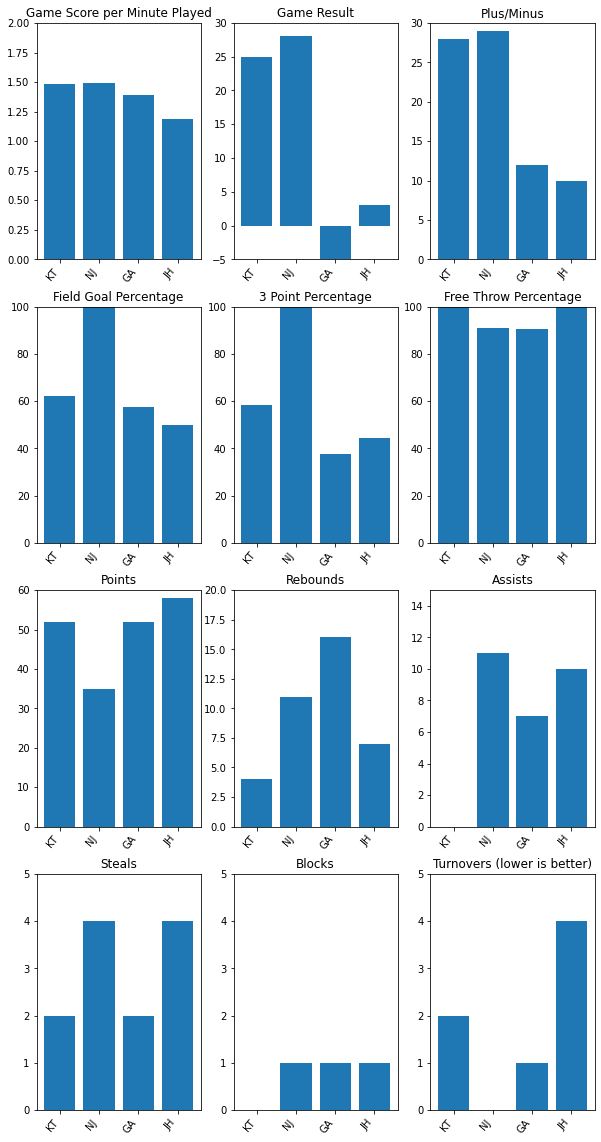

In [11]:
fig, ax = plt.subplots(4, 3, figsize=(10,20))

def get_game_result(game):
    result = game['game_result'].split(')')
    return float(result[0][-2:])

major_stats = [['gs_per_mp', 'game_result', 'plus_minus'],
               ['fg_pct', 'fg3_pct', 'ft_pct'],
               ['pts', 'trb', 'ast'],
               ['stl', 'blk', 'tov']]

ax[0][0].bar([get_initials(game) for game in convex_hull], [get_game_score_per_minute(game) for game in convex_hull]);
ax[0][0].set_xticks([get_initials(game) for game in convex_hull])
ax[0][0].set_xticklabels([get_initials(game) for game in convex_hull], rotation=50, ha='right');
ax[0][0].set_ylim([0, 2])
ax[0][0].title.set_text('Game Score per Minute Played')

ax[0][1].bar([get_initials(game) for game in convex_hull], [get_game_result(game) for game in convex_hull]);
ax[0][1].set_xticks([get_initials(game) for game in convex_hull])
ax[0][1].set_xticklabels([get_initials(game) for game in convex_hull], rotation=50, ha='right');
ax[0][1].set_ylim([-5, 30])
ax[0][1].title.set_text('Game Result')

ax[0][2].bar([get_initials(game) for game in convex_hull], [float(game['plus_minus']) for game in convex_hull]);
ax[0][2].set_xticks([get_initials(game) for game in convex_hull])
ax[0][2].set_xticklabels([get_initials(game) for game in convex_hull], rotation=50, ha='right');
ax[0][2].set_ylim([0, 30])
ax[0][2].title.set_text('Plus/Minus')

ax[1][0].bar([get_initials(game) for game in convex_hull], [100*float(game['fg_pct']) for game in convex_hull]);
ax[1][0].set_xticks([get_initials(game) for game in convex_hull])
ax[1][0].set_xticklabels([get_initials(game) for game in convex_hull], rotation=50, ha='right');
ax[1][0].set_ylim([0, 100])
ax[1][0].title.set_text('Field Goal Percentage')

ax[1][1].bar([get_initials(game) for game in convex_hull], [100*float(game['fg3_pct']) for game in convex_hull]);
ax[1][1].set_xticks([get_initials(game) for game in convex_hull])
ax[1][1].set_xticklabels([get_initials(game) for game in convex_hull], rotation=50, ha='right');
ax[1][1].set_ylim([0, 100])
ax[1][1].title.set_text('3 Point Percentage')

ax[1][2].bar([get_initials(game) for game in convex_hull], [100*float(game['ft_pct']) for game in convex_hull]);
ax[1][2].set_xticks([get_initials(game) for game in convex_hull])
ax[1][2].set_xticklabels([get_initials(game) for game in convex_hull], rotation=50, ha='right');
ax[1][2].set_ylim([0, 100])
ax[1][2].title.set_text('Free Throw Percentage')

ax[2][0].bar([get_initials(game) for game in convex_hull], [float(game['pts']) for game in convex_hull]);
ax[2][0].set_xticks([get_initials(game) for game in convex_hull])
ax[2][0].set_xticklabels([get_initials(game) for game in convex_hull], rotation=50, ha='right');
ax[2][0].set_ylim([0, 60])
ax[2][0].title.set_text('Points')

ax[2][1].bar([get_initials(game) for game in convex_hull], [float(game['trb']) for game in convex_hull]);
ax[2][1].set_xticks([get_initials(game) for game in convex_hull])
ax[2][1].set_xticklabels([get_initials(game) for game in convex_hull], rotation=50, ha='right');
ax[2][1].set_ylim([0, 20])
ax[2][1].title.set_text('Rebounds')

ax[2][2].bar([get_initials(game) for game in convex_hull], [float(game['ast']) for game in convex_hull]);
ax[2][2].set_xticks([get_initials(game) for game in convex_hull])
ax[2][2].set_xticklabels([get_initials(game) for game in convex_hull], rotation=50, ha='right');
ax[2][2].set_ylim([0, 15])
ax[2][2].title.set_text('Assists')

ax[3][0].bar([get_initials(game) for game in convex_hull], [float(game['stl']) for game in convex_hull]);
ax[3][0].set_xticks([get_initials(game) for game in convex_hull])
ax[3][0].set_xticklabels([get_initials(game) for game in convex_hull], rotation=50, ha='right');
ax[3][0].set_ylim([0, 5])
ax[3][0].title.set_text('Steals')

ax[3][1].bar([get_initials(game) for game in convex_hull], [float(game['blk']) for game in convex_hull]);
ax[3][1].set_xticks([get_initials(game) for game in convex_hull])
ax[3][1].set_xticklabels([get_initials(game) for game in convex_hull], rotation=50, ha='right');
ax[3][1].set_ylim([0, 5])
ax[3][1].title.set_text('Blocks')

ax[3][2].bar([get_initials(game) for game in convex_hull], [float(game['tov']) for game in convex_hull]);
ax[3][2].set_xticks([get_initials(game) for game in convex_hull])
ax[3][2].set_xticklabels([get_initials(game) for game in convex_hull], rotation=50, ha='right');
ax[3][2].set_ylim([0, 5])
ax[3][2].title.set_text('Turnovers (lower is better)')

At this point everything comes subjective.  For example, can you really even take Giannis Antetokounmpo into consideration for best game of the season when he lost even though he did this against by far the best opponent?  James Harden had the most points and highest game score, but was pretty mediocre everywhere else.  Klay Thompson's numbers weren't anything insane until you look at the fact that he did all of that in 26:33 of play time with an unbelievable plus/minus of +28 points* without a single assist, but he didn't even play the whole game and had a significantly lower game score than anyone else.

However, if I had to choose, I would go with Nikola Jokić.  As mentioned, Giannis Antetokounmpo had a monstrous game against an incredibly talented 76ers team, but lost.  Nikola Jokić on the other hand had the highest game score per minute, his team won by the largest margin (+28), he had the highest plus/minus of +29, tied for the most steals with 4, and didn't miss a single field goal attempt (although he did miss one free throw).  Further, he did this all while playing only just over 30 minutes AND had the most assists, which means he wasn't even playing selfishly to get all of these insane stats.



*for those who don't watch basketball, this means that on average while Klay was on the court his team net 28 gained more than their opponents

## Season by Season Stats

Now we switch to looking at Seasons.  We could certainly do a similar thing to figure out who had the "best season," but that'd be boring.  Instead, let's analyze trends of the average/best production values of a player based on league averages/bests in previous seasons.  For this, we'll use per game stats for each player that played each season that played more than 20 games (about a quarter of the season, aka didn't have a devasting injury near the beginning of the year).

Note that throughout gathering the data, there will be some other qualifiers, such as a mininum number of 3 point attempts when looking at 3 point %.

In [12]:
os.chdir('../sort_by_season/per_game')

In [13]:
stats_by_season = {}
for file in os.listdir():
    with open(file, 'r', encoding = 'cp850') as csv_file:
        reader = csv.DictReader(csv_file)
        year = int(file.split('.')[0])
        stats_by_season[year] = {stat:[] for stat in reader.fieldnames}
        for row in reader:
            if float(row['g']) < 20:
                continue
            for key, value in row.items():
                try:
                    if key == 'fg3_pct':
                        if float(row['g'])*float(row['fg3a_per_g']) >= 15:
                            stats_by_season[year][key].append(float(value))
                    elif key == 'fg2_pct':
                        if float(row['g'])*float(row['fg2a_per_g']) >= 15:
                            stats_by_season[year][key].append(float(value))
                    elif key == 'ft_pct':
                        if float(row['g'])*float(row['fta_per_g']) >= 15:
                            stats_by_season[year][key].append(float(value))
                    else:
                        stats_by_season[year][key].append(float(value))

                except:
                    pass

# get rid of any stats that aren't numbers
# https://stackoverflow.com/questions/12118695/efficient-way-to-remove-keys-with-empty-strings-from-a-dict
for key in stats_by_season.keys():
    stats_by_season[key] = {k: v for k, v in stats_by_season[key].items() if len(v)>0 and k not in ['g', 'gs']}

First, we'll obtain the averages of each statistic as well as the best of each season.

In [14]:
averages = {}
best = {}
max_year = max(stats_by_season.keys())
first_year_of_stat = {stat:np.infty for stat in stats_by_season[max_year].keys()}
for year in stats_by_season.keys():
    averages[year] = {}
    best[year] = {}
    for stat, values in stats_by_season[year].items():
        first_year_of_stat[stat] = min(first_year_of_stat[stat], year)
        averages[year][stat] = np.mean(values)
        best[year][stat] = np.max(values)

Next, we'll plot as many important stats as possible.

In [15]:
stat_list = [['orb_per_g', 'drb_per_g', 'trb_per_g', 'fg_per_g', 'fga_per_g', 'fg_pct'],
             ['ft_per_g', 'fta_per_g', 'ft_pct', 'fg2_per_g', 'fg2a_per_g', 'fg2_pct'],
             ['fg3_per_g', 'fg3a_per_g', 'fg3_pct', 'efg_pct', 'mp_per_g', 'age'],
             ['pts_per_g', 'ast_per_g', 'blk_per_g', 'stl_per_g', 'tov_per_g', 'pf_per_g']]

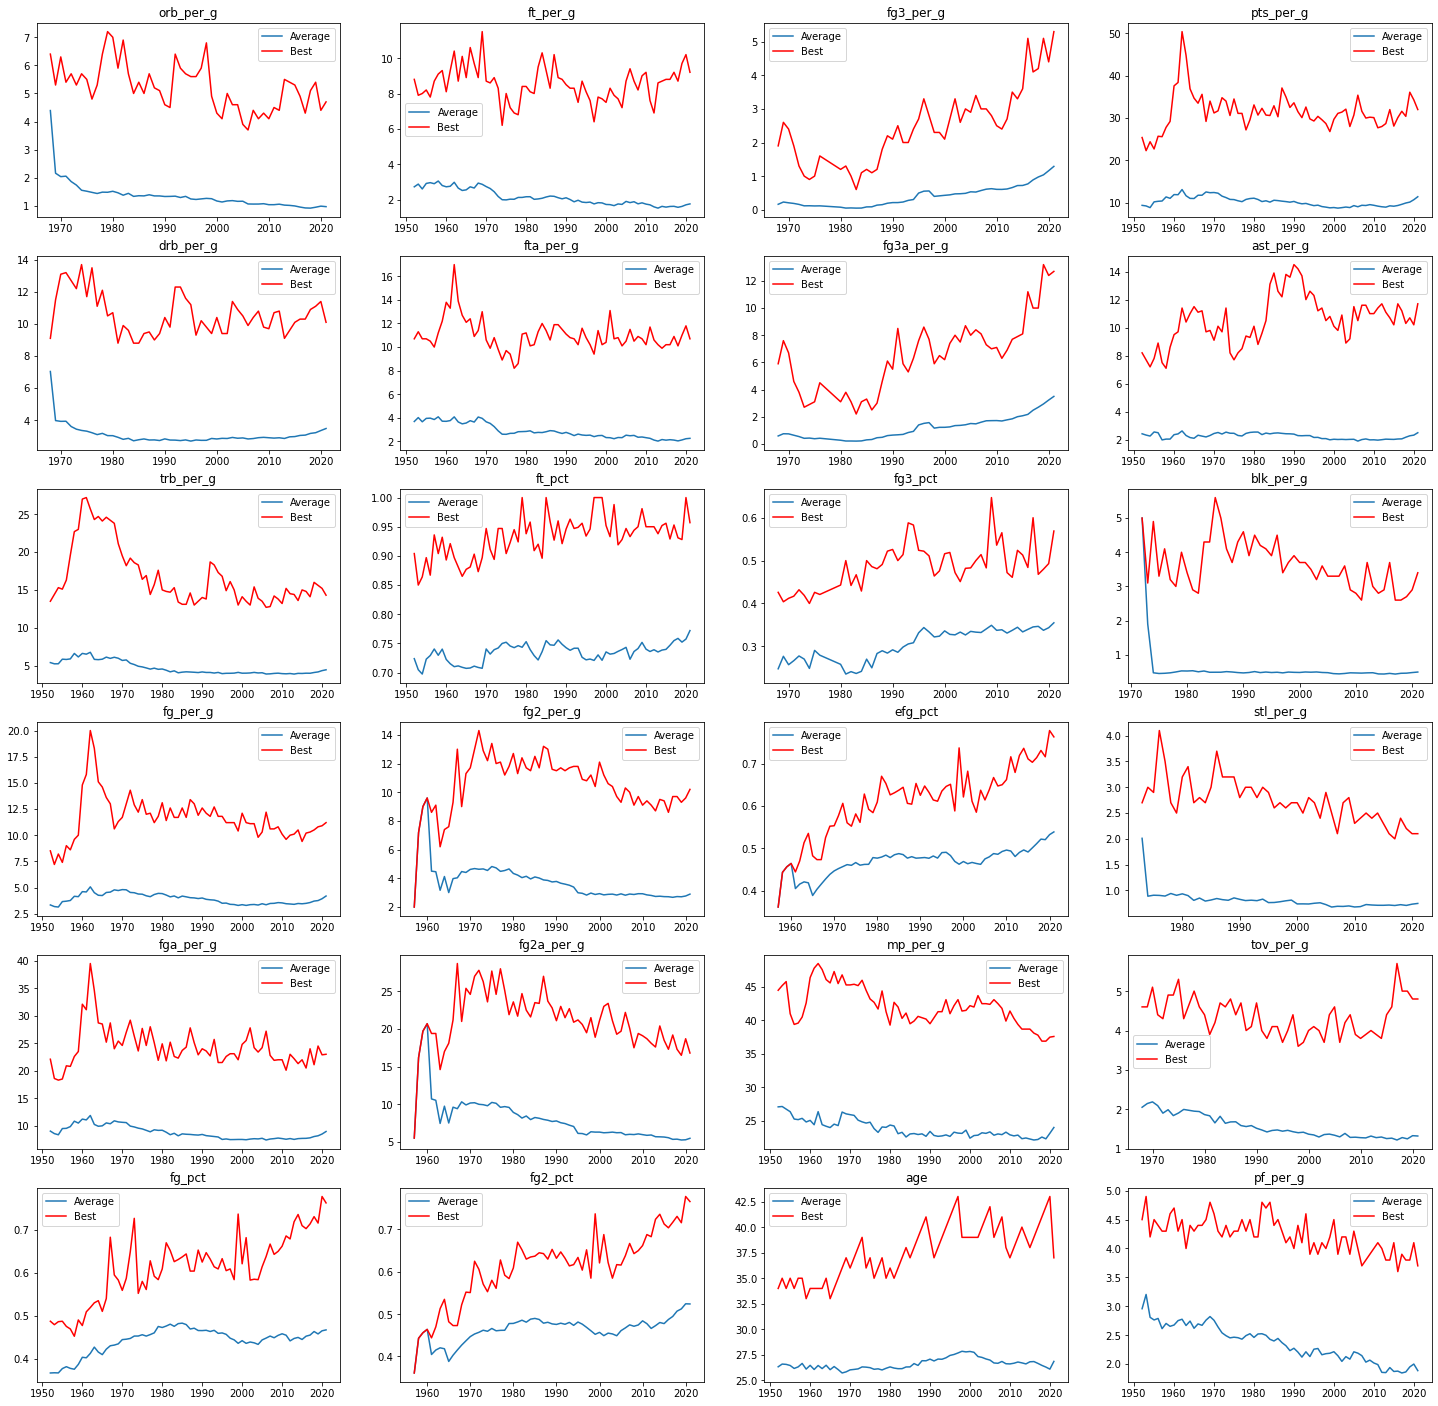

In [16]:
fig, ax = plt.subplots(6, 4, figsize=(25,25))

for j, cur_stats in enumerate(stat_list):
    for i, stat in enumerate(cur_stats):
        cur_averages = []
        cur_best = []
        useable_years = set()
        for year in range(first_year_of_stat[stat], max_year+1):
            try:
                cur_averages.append(averages[year][stat])
                cur_best.append(best[year][stat])
                useable_years.add(year)
            except:
                pass

        l1, = ax[i][j].plot([year for year in useable_years], cur_averages)
        l2, = ax[i][j].plot([year for year in useable_years], cur_best, color='red')
        ax[i][j].legend((l1, l2), ('Average', 'Best'));
        ax[i][j].title.set_text(stat)

Some graphs show a definitive pattern, and plenty don't.  Let's plot some basic lines of best fit to see if they provide any additional insight.

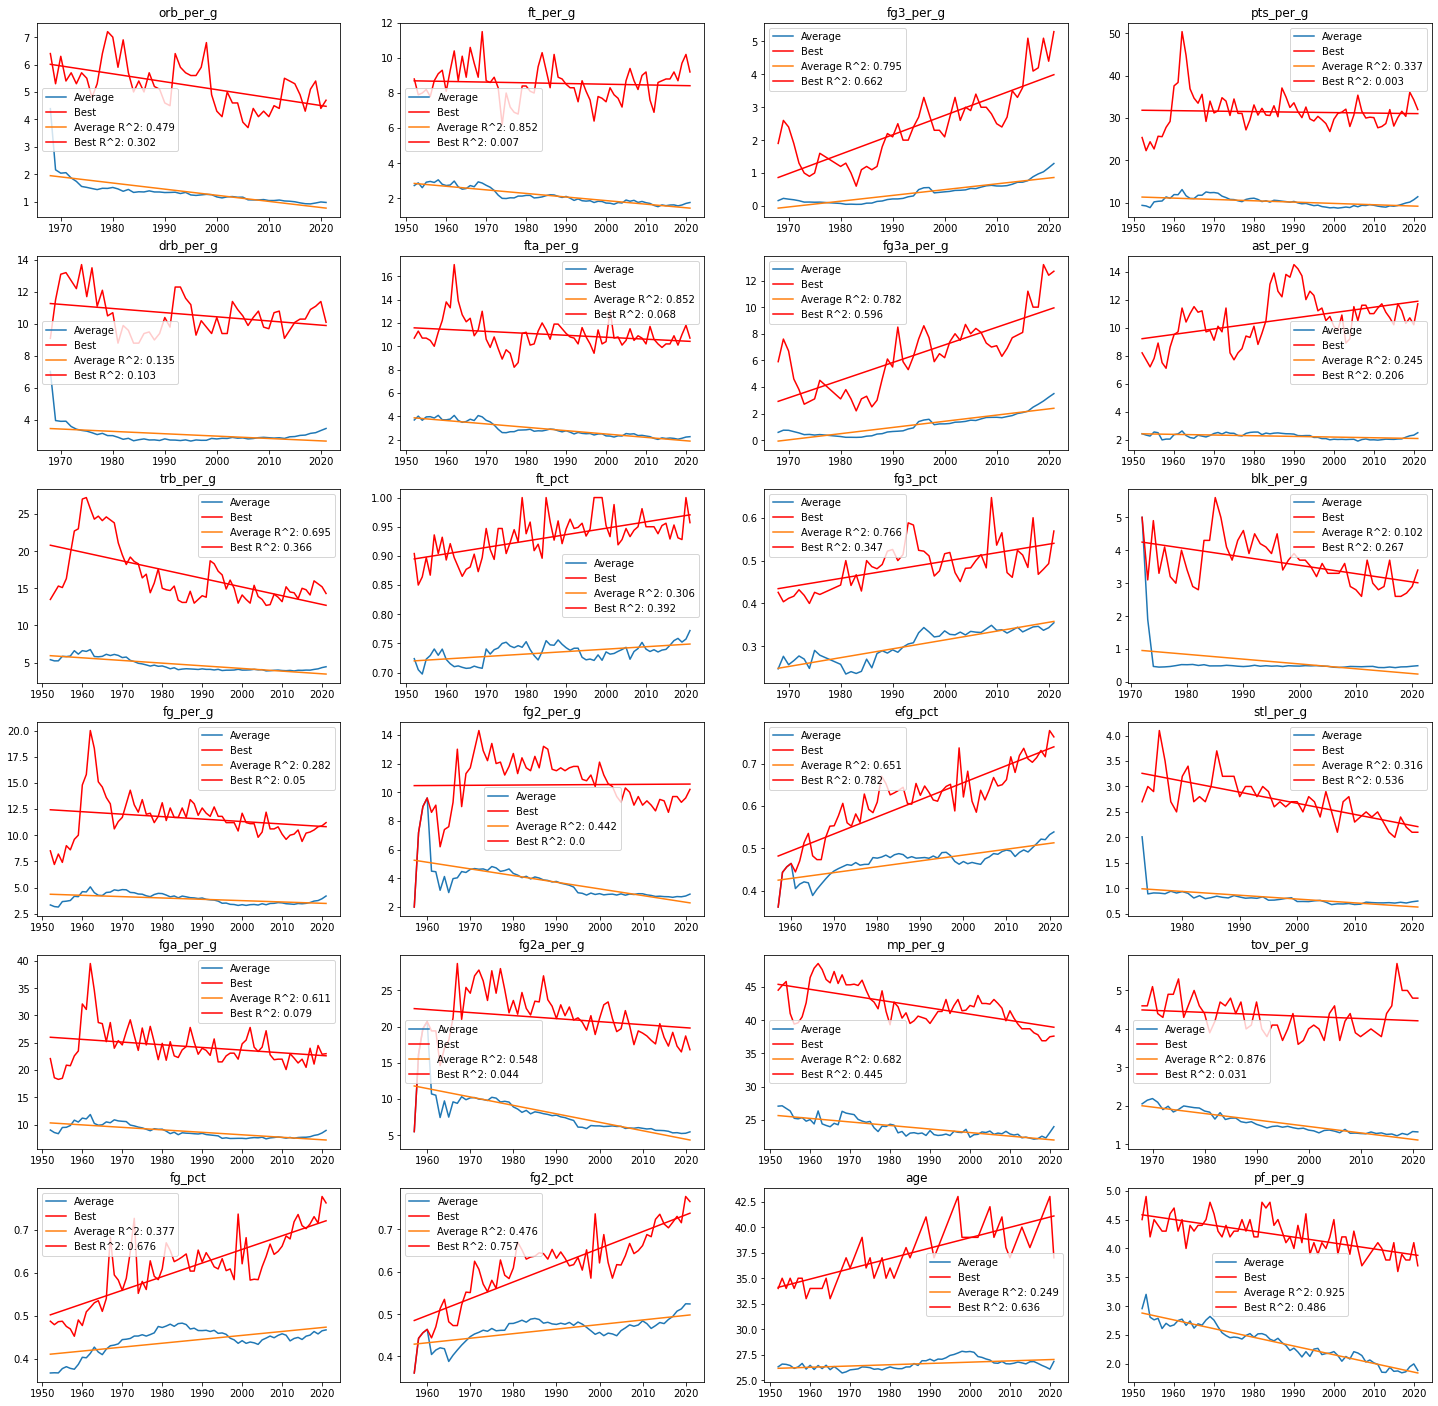

In [17]:
fig, ax = plt.subplots(6, 4, figsize=(25,25))

for j, cur_stats in enumerate(stat_list):
    for i, stat in enumerate(cur_stats):
        cur_averages = []
        cur_best = []
        useable_years = set()
        for year in range(first_year_of_stat[stat], max_year+1):
            try:
                cur_averages.append(averages[year][stat])
                cur_best.append(best[year][stat])
                useable_years.add(year)
            except:
                pass

        poly = PolynomialFeatures(degree=1) # can change this number for degree of polynomial regression you'd like
        X = np.array([year for year in useable_years]).reshape((-1,1))
        y = np.array(cur_averages).reshape((-1,1))
        avg_best_fit = LinearRegression().fit(poly.fit_transform(X),y)
        y = np.array(cur_best).reshape((-1,1))
        best_best_fit = LinearRegression().fit(poly.fit_transform(X),y)
        
        l1, = ax[i][j].plot(X, cur_averages)
        l2, = ax[i][j].plot(X, cur_best, color='red')
        l3, = ax[i][j].plot(X, avg_best_fit.predict(poly.fit_transform(X)), '-')
        l4, = ax[i][j].plot(X, best_best_fit.predict(poly.fit_transform(X)), '-', color='red')
        ax[i][j].legend((l1, l2, l3, l4), ('Average', 'Best', \
                                   'Average R^2: {}'.format(round(r2_score(cur_averages, avg_best_fit.predict(poly.fit_transform(X))), 3)),
                                   'Best R^2: {}'.format(round(r2_score(cur_best, best_best_fit.predict(poly.fit_transform(X))), 3))));
        ax[i][j].title.set_text(stat)

We have several observations here that are actually quite meaningful (with confirmation from the R^2 values), as well as plenty that aren't.  There are some interesting correlations such as personal fouls and free throw attempts (on average) both going in the same direction, as personal fouls are pretty much the only way you get free throws. You can also obviously see a strong correlation between field goal, 2 point, 3 point, and effective shooting percentage for obvious reasons.

There are certainly a couple more interesting inferences from these graphs as well.  For one, the average (and for the most part best as well) points per game has remained incredibly consistent DESPITE the average and highest minutes per game dropping overall.  That, if nthing else, shows how much the offense in the sport has improved relative to defense.  Another is that while average age hasn't really changed, the oldest person in the league has fairly consistently increased since the 50's, which can also somewhat be explained by the minutes played per game going down, as well as outside factors such as the immense leaps in strength and conditioning outside of the game.

We could find little correlations like these for a while, however there's one easy way to let the computer find them for us in the form of a correlation matrix.  Values will range between -1 and 1, where 0 signifies no correlation between two features, 1 signifies a direct positive correlation, and -1 signifies a direct inverse correlation.  Note that there is a little difficulty here sense there are some stats that are missing years, so we'll have to deal with that appropiately.  Here, we'll just fill in those spots with predictions from our regression models.

In [18]:
stat_list = ['orb_per_g', 'drb_per_g', 'trb_per_g', 'fg_per_g', 'fga_per_g', 'fg_pct',
             'ft_per_g', 'fta_per_g', 'ft_pct', 'fg2_per_g', 'fg2a_per_g', 'fg2_pct',
             'fg3_per_g', 'fg3a_per_g', 'fg3_pct', 'efg_pct', 'mp_per_g', 'age',
             'pts_per_g', 'ast_per_g', 'blk_per_g', 'stl_per_g', 'tov_per_g', 'pf_per_g']

lines_of_fit = {stat:0 for stat in stat_list}
all_years = list(range(1952, max_year+1))
corr_stats = [[] for year in all_years]
for stat in stat_list:
    cur_averages = {}
    useable_years = set()
    for year in range(first_year_of_stat[stat], max_year+1):
        try:
            cur_averages[year] = averages[year][stat]
            useable_years.add(year)
        except:
            pass
        
    X = np.array([year for year in useable_years]).reshape((-1,1))
    y = np.array(list(cur_averages.values())).reshape((-1,1))

    line_of_fit = LinearRegression().fit(poly.fit_transform(X), y)
    for i, year in enumerate(all_years):
        if year in useable_years:
            corr_stats[i].append(cur_averages[year])
        else:
            corr_stats[i].append(line_of_fit.predict(poly.fit_transform(np.array([[year]])))[0][0])
corr_stats = np.array(corr_stats).transpose()

In [19]:
corr_mat = np.corrcoef(corr_stats)
corr_mat = np.where(corr_mat >= 0.99999, 0, corr_mat) # ignore correlations of 1
corr_mat

array([[ 0.        ,  0.88155986,  0.821156  ,  0.51083623,  0.76423221,
        -0.59666769,  0.87250035,  0.88295001, -0.58496093,  0.56248346,
         0.64284438, -0.68222357, -0.70028347, -0.69131006, -0.75160607,
        -0.74796944,  0.81946992, -0.50881386,  0.61411215,  0.30682037,
         0.45904888,  0.64774665,  0.82266612,  0.81994849],
       [ 0.88155986,  0.        ,  0.68922116,  0.47116138,  0.66738226,
        -0.45520865,  0.64361777,  0.65131341, -0.37280591,  0.36817998,
         0.43411622, -0.46146419, -0.31025467, -0.29748086, -0.44785643,
        -0.48523967,  0.69447969, -0.54070523,  0.59511397,  0.17108633,
         0.38173411,  0.47077179,  0.58511239,  0.54243123],
       [ 0.821156  ,  0.68922116,  0.        ,  0.64398562,  0.94393802,
        -0.69201194,  0.91930889,  0.91922183, -0.52771085,  0.6523939 ,
         0.74230907, -0.72020085, -0.69038939, -0.68109016, -0.75721268,
        -0.77067808,  0.81150878, -0.5685621 ,  0.76775664,  0.33770486,
  

We can look everywhere ourselves to find pretty strong correlations, but we'll just look at a few near the top for now.  Note here that we're ignoring the top few as they're pretty obvious (fg3a_per_g and fg3_per_g, etc.).

In [20]:
num_corrs = 25
indices = np.argpartition(np.abs(corr_mat).flatten(), -2*num_corrs)[-2*num_corrs:-num_corrs]
indices = [divmod(ind, 24) for ind in indices]
for stat1, stat2 in indices:
    print(stat_list[stat1], stat_list[stat2])

orb_per_g ft_per_g
mp_per_g tov_per_g
trb_per_g tov_per_g
ft_per_g orb_per_g
tov_per_g trb_per_g
tov_per_g mp_per_g
orb_per_g drb_per_g
drb_per_g orb_per_g
tov_per_g ft_per_g
tov_per_g fta_per_g
fg_per_g pts_per_g
fg2_pct efg_pct
fg2a_per_g fg2_per_g
fg3_per_g fg3a_per_g
fg2_per_g fg2a_per_g
fga_per_g trb_per_g
tov_per_g fg3_pct
fg3_per_g fg3_pct
fta_per_g pf_per_g
fta_per_g tov_per_g
fta_per_g ft_per_g
fg3_per_g pf_per_g
fg3a_per_g fg3_per_g
fg3a_per_g fg3_pct
fta_per_g trb_per_g


Here we observe some fairly interesting correlations.  Turnovers per game and both free throws and free throws attempted per game seemed to have a relatively strong correlation, as well as offensive rebounds per game and free throws per game.  Turnovers per game is also correlated with minutes played per game, potentially signifying that the more someone plays during a game the higher likelihood it is that they turn the ball over (presumably later in the game when they're tired).

We could look into these all day, as well as go radically increase the number of features we're looking at (multiplying features together, namely).  With this many important statistics, there's almost a guarantee that you can further find meaningful correlations the more you look for quite a while.

## Player by Season Stats

The last exploration we'll do here will utilize the directory where we split up the data by player's season totals.  Here, we'll try and find what players "level up" and players forget how to play the game in the playoffs (in comparison to the corresponding regular season).

In [21]:
os.chdir('../../sort_by_player/playoffs_advanced')

In [71]:
playoffs_stats_by_player = {}
for file in os.listdir():
    with open(file, 'r', encoding = 'cp850') as csv_file:
        reader = csv.DictReader(csv_file)
        name = file[:-4]
        playoffs_stats_by_player[name] = {}
        stats = reader.fieldnames.copy()
        stats.remove('year') # don't store year twice
        for row in reader:
            playoffs_stats_by_player[name][float(row['year'])] = {}
            for stat in stats:
                try:
                    playoffs_stats_by_player[name][float(row['year'])][stat] = float(row[stat])
                except:
                    pass

In [74]:
os.chdir('../advanced')

In [91]:
rs_stats_by_player = {}
bad_list = []
for name in playoffs_stats_by_player.keys():
    with open(name+'.csv', 'r', encoding = 'cp850') as csv_file:
        reader = csv.DictReader(csv_file)
        rs_stats_by_player[name] = {year:{} for year in playoffs_stats_by_player[name].keys()}
        for row in reader:
            year = float(row['year'])
            if year in rs_stats_by_player[name].keys():
                for stat in playoffs_stats_by_player[name][year].keys():
                    try:
                        rs_stats_by_player[name][year][stat] = float(row[stat])
                    except:
                        bad_list.append((name, year, stat))

for name, year, stat in bad_list:
    playoffs_stats_by_player[name][year].pop(stat)

In [94]:
playoffs_vs_rs_stats = {name:{year:{} for year in rs_stats_by_player[name].keys()} for name in rs_stats_by_player.keys()}
for name in rs_stats_by_player.keys():
    for year in rs_stats_by_player[name].keys():
        for stat in rs_stats_by_player[name][year].keys():
            if stat in ['age', 'g', 'mp', 'ws']: # no point in comparing these stats that aren't averages
                continue
            playoffs_vs_rs_stats[name][year][stat] = playoffs_stats_by_player[name][year][stat] - rs_stats_by_player[name][year][stat]

We have plenty of stats to compare here, but initially we'll just use PER (player efficiency rating, similar to game score) for each season a player was in the playoffs just to get an idea of what "usually" happens in the playoffs.

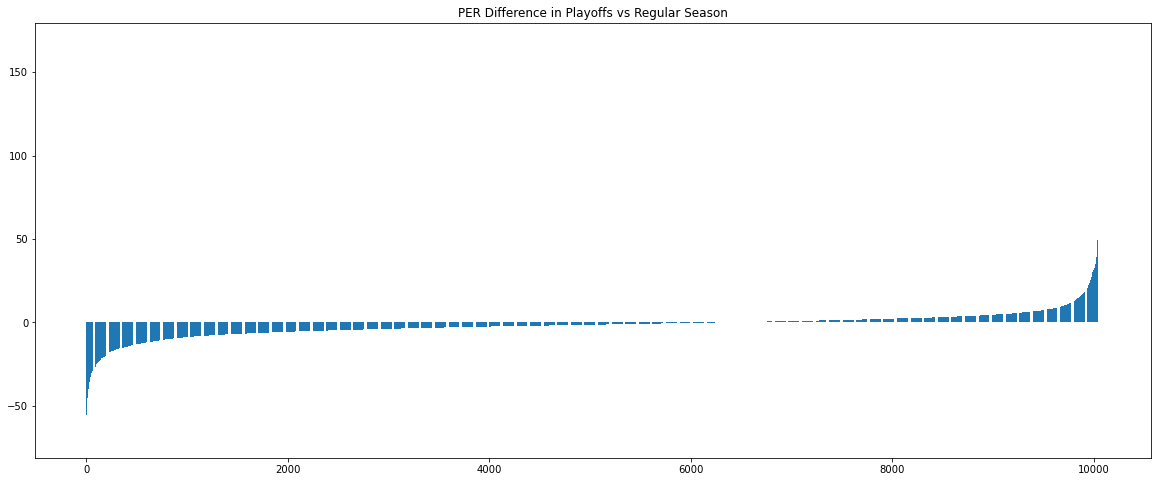

In [123]:
name_year = []
per_diff  = []
for name in playoffs_vs_rs_stats.keys():
    for year in playoffs_vs_rs_stats[name].keys():
        if 'per' in playoffs_vs_rs_stats[name][year].keys():
            useable_name = name + '_' + str(year)
            name_year.append(useable_name)
            per_diff.append(playoffs_vs_rs_stats[name][year]['per'])

name_year = [year for _, year in sorted(zip(per_diff, name_year))]
per_diff = sorted(per_diff)

            
fig, ax = plt.subplots(1,1, figsize=(20,8))

ax.bar([i for i in range(len(per_diff))], per_diff);
# ax.set_xticks([i for i in range(len(per_diff))])
# ax.set_xticklabels(name_year, rotation=50, ha='right');
ax.title.set_text('PER Difference in Playoffs vs Regular Season')

It's pretty clear that most people slump in the playoffs, even if only a little.  There are clearly some outliers even at the extremes, so they'll require a special look initially.

In [125]:
name_year[0]

'Eddie Gill_2006.0'

In [126]:
playoffs_stats_by_player['Eddie Gill'][2006]

{'age': 27.0,
 'g': 2.0,
 'mp': 1.0,
 'per': -59.5,
 'orb_pct': 0.0,
 'drb_pct': 0.0,
 'trb_pct': 0.0,
 'ast_pct': 0.0,
 'stl_pct': 0.0,
 'blk_pct': 0.0,
 'tov_pct': 100.0,
 'usg_pct': 48.9,
 'ows': 0.0,
 'dws': 0.0,
 'ws': 0.0,
 'ws_per_48': -1.572,
 'obpm': -27.7,
 'dbpm': -16.2,
 'bpm': -43.9,
 'vorp': 0.0}

In [181]:
name_year[-1]

'Jack Nichols_1954.0'

In [127]:
playoffs_stats_by_player['Lester Conner'][1988]

{'age': 28.0,
 'g': 1.0,
 'mp': 1.0,
 'per': 181.3,
 'ts_pct': 1.136,
 'orb_pct': 0.0,
 'drb_pct': 100.0,
 'trb_pct': 55.3,
 'ast_pct': 100.0,
 'stl_pct': 50.4,
 'blk_pct': 0.0,
 'tov_pct': 0.0,
 'usg_pct': 37.1,
 'ows': 0.0,
 'dws': 0.0,
 'ws': 0.1,
 'ws_per_48': 2.621,
 'obpm': 59.0,
 'dbpm': 84.3,
 'bpm': 143.4,
 'vorp': 0.0}

Each of these anomalies stem from different sides of the same coin.  Eddie Gill, according to this, is simply the worst playoff player in the history of basketball based on this metric, but he played for a total of 1 minute across 2 games and only had 1 turnovers as his only stat line.  Then there's Lester Conner, who similarly is apparently the greatest athlete ever because he played 1 minute, attempted 1 field goal and made it.

This is a classic case of not having requirements on data that we forgot to add, so now we'll do the same exact procedure and require that people played at least 48 minutes (1 full game) in the playoffs in order to consider them.

In [313]:
os.chdir('../playoffs_advanced')

In [314]:
playoffs_stats_by_player = {}
for file in os.listdir():
    with open(file, 'r', encoding = 'cp850') as csv_file:
        reader = csv.DictReader(csv_file)
        name = file[:-4]
        playoffs_stats_by_player[name] = {}
        stats = reader.fieldnames.copy()
        stats.remove('year') # don't store year twice
        for row in reader:
            if row['mp'] != '' and float(row['mp']) >= 48:
                playoffs_stats_by_player[name][float(row['year'])] = {}
                for stat in stats:
                    try:
                        playoffs_stats_by_player[name][float(row['year'])][stat] = float(row[stat])
                    except:
                        pass

In [315]:
os.chdir('../advanced')

In [316]:
rs_stats_by_player = {}
bad_list = []
for name in playoffs_stats_by_player.keys():
    with open(name+'.csv', 'r', encoding = 'cp850') as csv_file:
        reader = csv.DictReader(csv_file)
        rs_stats_by_player[name] = {year:{} for year in playoffs_stats_by_player[name].keys()}
        for row in reader:
            year = float(row['year'])
            if year in rs_stats_by_player[name].keys():
                for stat in playoffs_stats_by_player[name][year].keys():
                    try:
                        rs_stats_by_player[name][year][stat] = float(row[stat])
                    except:
                        bad_list.append((name, year, stat))

for name, year, stat in bad_list:
    playoffs_stats_by_player[name][year].pop(stat)

In [317]:
playoffs_vs_rs_stats = {name:{year:{} for year in rs_stats_by_player[name].keys()} for name in rs_stats_by_player.keys()}
for name in rs_stats_by_player.keys():
    for year in rs_stats_by_player[name].keys():
        for stat in rs_stats_by_player[name][year].keys():
            if stat in ['age', 'g', 'mp', 'ws']: # no point in comparing these stats that aren't averages
                continue
            playoffs_vs_rs_stats[name][year][stat] = playoffs_stats_by_player[name][year][stat] - rs_stats_by_player[name][year][stat]

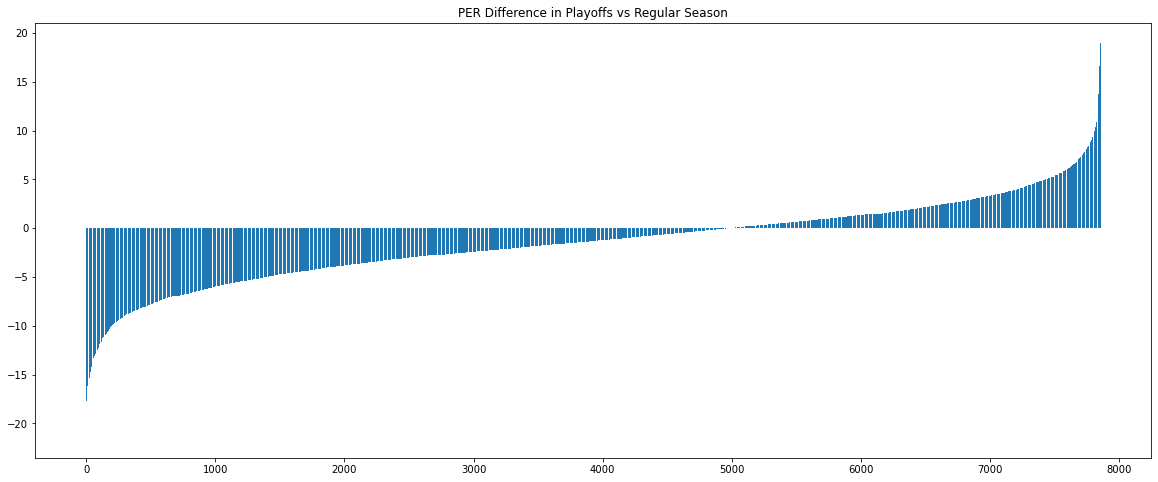

In [318]:
name_year = []
per_diff  = []
for name in playoffs_vs_rs_stats.keys():
    for year in playoffs_vs_rs_stats[name].keys():
        if 'per' in playoffs_vs_rs_stats[name][year].keys():
            useable_name = name + '_' + str(year)
            name_year.append(useable_name)
            per_diff.append(playoffs_vs_rs_stats[name][year]['per'])

name_year = [year for _, year in sorted(zip(per_diff, name_year))]
per_diff = sorted(per_diff)

            
fig, ax = plt.subplots(1,1, figsize=(20,8))

ax.bar([i for i in range(len(per_diff))], per_diff);
# ax.set_xticks([i for i in range(len(per_diff))])
# ax.set_xticklabels(name_year, rotation=50, ha='right');
ax.title.set_text('PER Difference in Playoffs vs Regular Season')

To observe the best and worst individual changes from regular season to playoffs, here's the top 25 of both on the same graph.

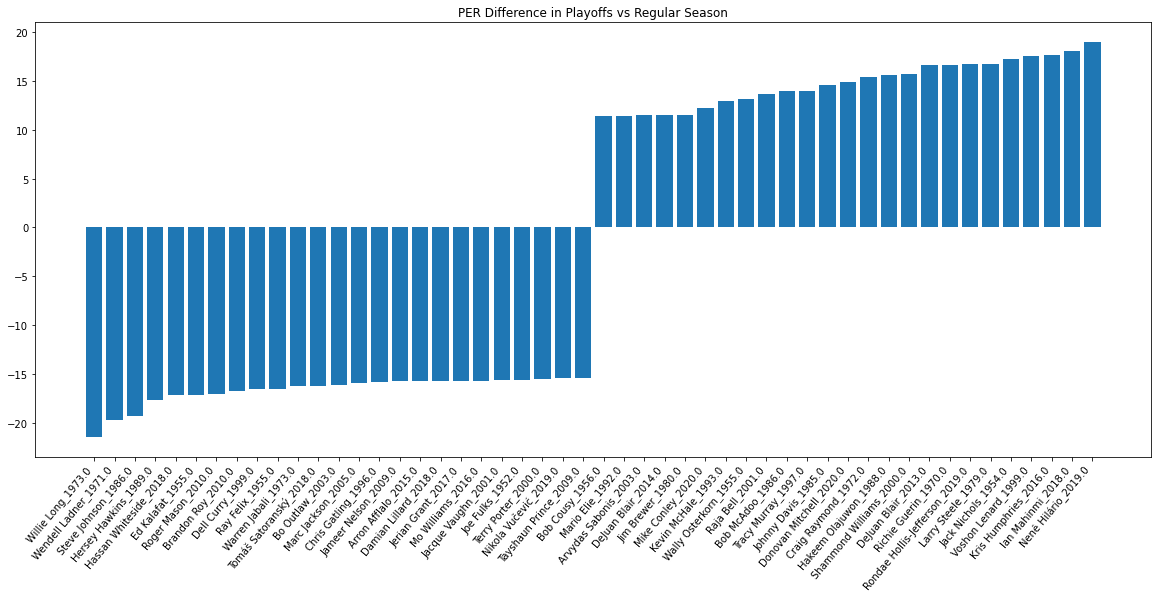

In [319]:
worst_best_name_year = name_year[:25] + name_year[-25:]
worst_best_per_diff = per_diff[:25] + per_diff[-25:]

fig, ax = plt.subplots(1,1, figsize=(20,8))

ax.bar([i for i in range(len(worst_best_per_diff))], worst_best_per_diff);
ax.set_xticks([i for i in range(len(worst_best_per_diff))])
ax.set_xticklabels(worst_best_name_year, rotation=50, ha='right');
ax.title.set_text('PER Difference in Playoffs vs Regular Season')

To get a better idea of how players overall change effectiveness from the regular season to the playoffs, we'll take an average of each player's change for each season (assuming they meaningfully played in at least 5 playoffs).

In [332]:
total_diff = {}
for name in playoffs_stats_by_player.keys():
    if len(playoffs_vs_rs_stats[name].keys()) >= 3:
        total_diff[name] = {'games':[]}
        for year in playoffs_vs_rs_stats[name].keys():
            try:
                total_diff[name]['games'].append(playoffs_vs_rs_stats[name][year]['per'])
            except:
                continue
        total_diff[name]['avg'] = np.mean(total_diff[name]['games'])
        total_diff[name]['std'] = np.std(total_diff[name]['games'])

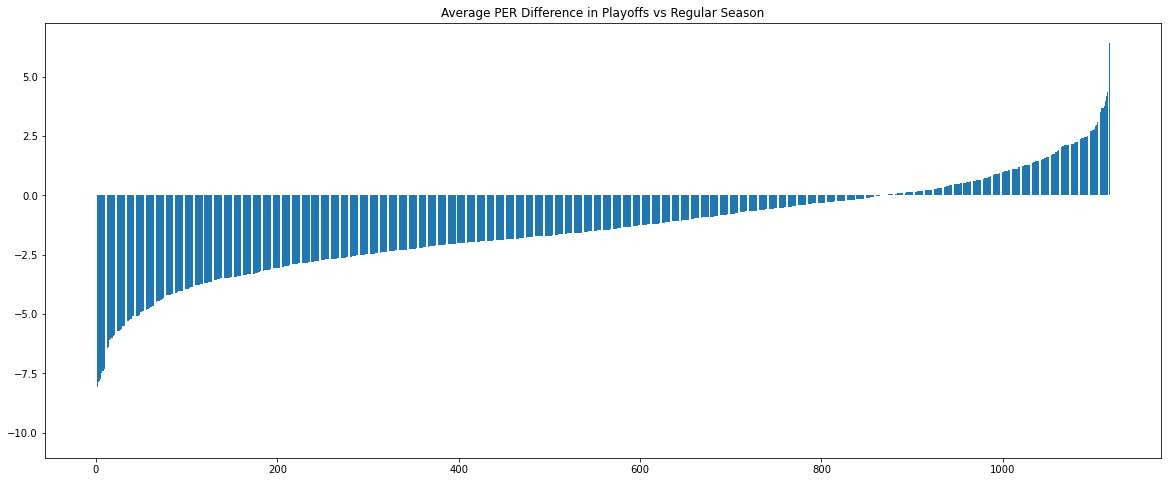

In [333]:
names = []
per_diff  = []
for name in total_diff.keys():
    names.append(name)
    per_diff.append(total_diff[name]['avg'])

names = [year for _, year in sorted(zip(per_diff, names))]
per_diff = sorted(per_diff)

            
fig, ax = plt.subplots(1,1, figsize=(20,8))

ax.bar([i for i in range(len(per_diff))], per_diff);
# ax.set_xticks([i for i in range(len(per_diff))])
# ax.set_xticklabels(name_year, rotation=50, ha='right');
ax.title.set_text('Average PER Difference in Playoffs vs Regular Season')

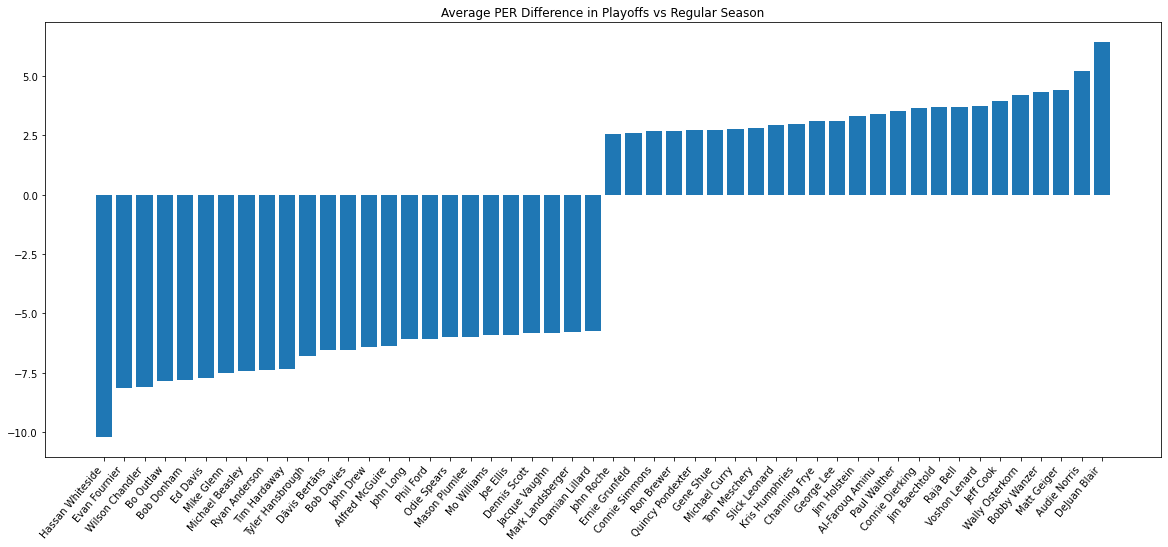

In [334]:
worst_best_name_year = names[:25] + names[-25:]
worst_best_per_diff = per_diff[:25] + per_diff[-25:]

fig, ax = plt.subplots(1,1, figsize=(20,8))

ax.bar([i for i in range(len(worst_best_per_diff))], worst_best_per_diff);
ax.set_xticks([i for i in range(len(worst_best_per_diff))])
ax.set_xticklabels(worst_best_name_year, rotation=50, ha='right');
ax.title.set_text('Average PER Difference in Playoffs vs Regular Season')

We can also look at who's the most and least consistent when it comes to the playoffs:

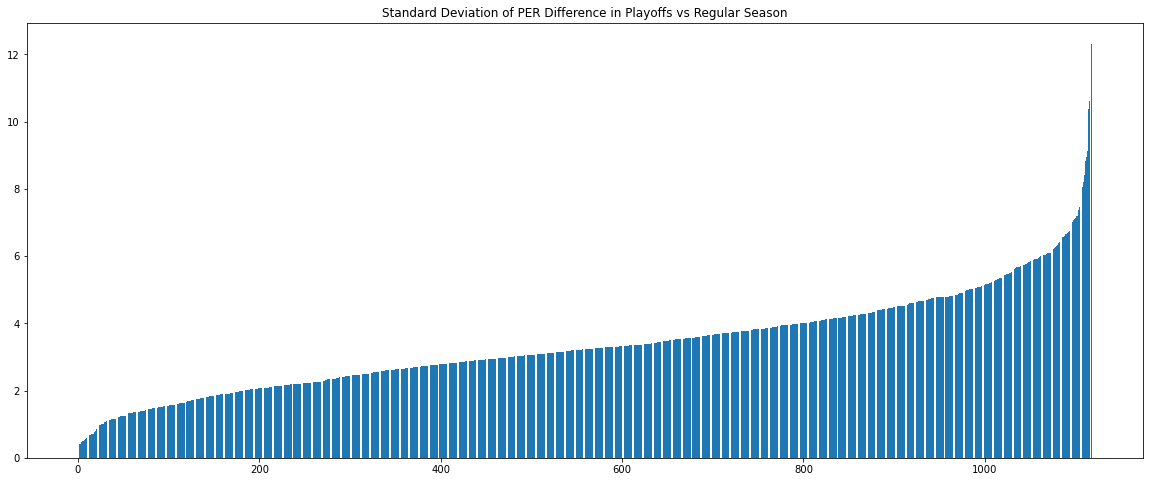

In [335]:
names = []
per_diff  = []
for name in total_diff.keys():
    names.append(name)
    per_diff.append(total_diff[name]['std'])

names = [year for _, year in sorted(zip(per_diff, names))]
per_diff = sorted(per_diff)

            
fig, ax = plt.subplots(1,1, figsize=(20,8))

ax.bar([i for i in range(len(per_diff))], per_diff);
# ax.set_xticks([i for i in range(len(per_diff))])
# ax.set_xticklabels(name_year, rotation=50, ha='right');
ax.title.set_text('Standard Deviation of PER Difference in Playoffs vs Regular Season')

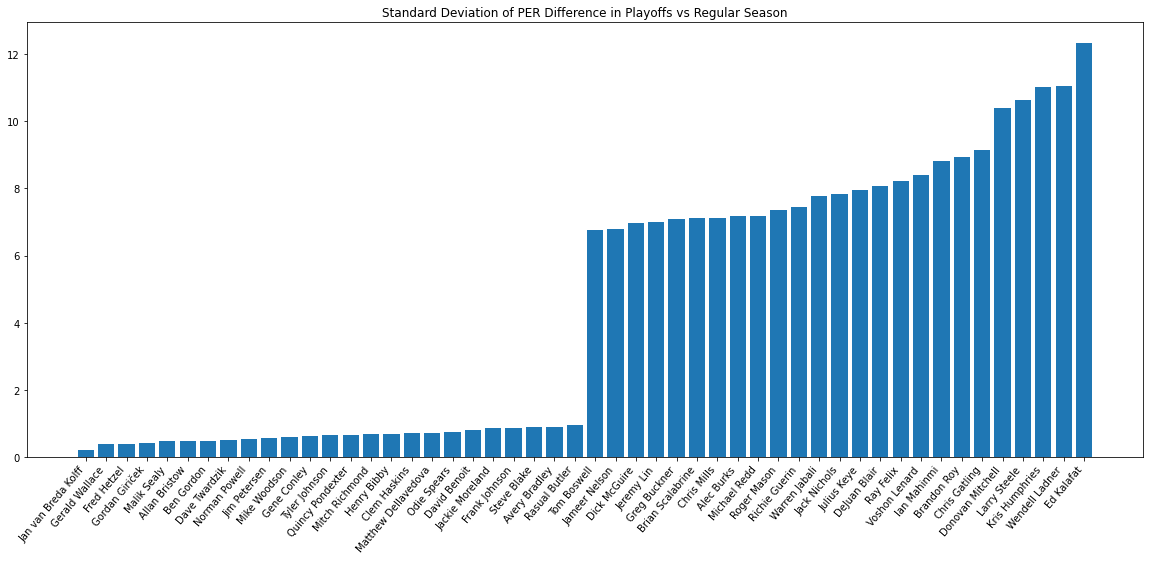

In [336]:
worst_best_name_year = names[:25] + names[-25:]
worst_best_per_diff = per_diff[:25] + per_diff[-25:]

fig, ax = plt.subplots(1,1, figsize=(20,8))

ax.bar([i for i in range(len(worst_best_per_diff))], worst_best_per_diff);
ax.set_xticks([i for i in range(len(worst_best_per_diff))])
ax.set_xticklabels(worst_best_name_year, rotation=50, ha='right');
ax.title.set_text('Standard Deviation of PER Difference in Playoffs vs Regular Season')